In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import mean_absolute_error 

%matplotlib inline

In [2]:
class PacienteDiabetesEnvAprimorado:
    def __init__(self, glicemia_inicial=180, sensibilidade_insulina=30):
        self.num_faixas_glicemia = 3
        self.num_tendencias = 2
        self.num_faixas_tempo_refeicao = 3
        self.num_estados = self.num_faixas_glicemia * self.num_tendencias * self.num_faixas_tempo_refeicao
        self.ACOES = {0: 0, 1: 2, 2: -2}
        self.num_acoes = len(self.ACOES)
        self.glicemia_mg_dL = glicemia_inicial
        self.glicemia_historico = [glicemia_inicial]
        self.dose_insulina_base = 10 
        self.insulina_circulante = 0
        self.carboidrato_ativo = 0
        self.tempo_desde_refeicao_passos = 1000 
        self.sensibilidade_insulina = sensibilidade_insulina
        self.fator_carboidrato = 4 
        self.PENALIDADE_HIPO_SEVERA = -200
        self.PENALIDADE_HIPO_LEVE = -50
        
    def obter_faixa_tempo_refeicao(self):
        passos_por_hora = 4 
        if self.tempo_desde_refeicao_passos < 2 * passos_por_hora: return 0
        elif self.tempo_desde_refeicao_passos < 4 * passos_por_hora: return 1
        else: return 2
            
    def obter_estado_discreto(self):
        if self.glicemia_mg_dL < 70: faixa_gli = 0
        elif 70 <= self.glicemia_mg_dL <= 180: faixa_gli = 1
        else: faixa_gli = 2
            
        if len(self.glicemia_historico) >= 2:
            delta_glicemia = self.glicemia_mg_dL - self.glicemia_historico[-2]
            tendencia = 1 if delta_glicemia > 5 else 0 
        else: tendencia = 0
            
        faixa_tempo = self.obter_faixa_tempo_refeicao()
        estado = (faixa_gli * self.num_tendencias * self.num_faixas_tempo_refeicao) + \
                 (tendencia * self.num_faixas_tempo_refeicao) + \
                 faixa_tempo
        return estado

    def step(self, acao_idx):
        ajuste_insulina = self.ACOES[acao_idx]
        self.dose_insulina_base += ajuste_insulina
        self.dose_insulina_base = max(0, self.dose_insulina_base)
        
        self.insulina_circulante = 0.8 * self.insulina_circulante + 0.2 * self.dose_insulina_base
        efeito_insulina = (self.insulina_circulante / 10) * self.sensibilidade_insulina
        
        if random.random() < 0.1 and self.tempo_desde_refeicao_passos > (4 * 4): 
            self.carboidrato_ativo += 50 
            self.tempo_desde_refeicao_passos = 0 
            
        self.tempo_desde_refeicao_passos += 1
            
        efeito_carboidrato = (self.carboidrato_ativo / 5) * self.fator_carboidrato
        self.carboidrato_ativo = max(0, self.carboidrato_ativo * 0.9)
        
        fator_basal = 5
        ruido = np.random.uniform(-5, 5)
        
        mudanca_liquida = fator_basal + efeito_carboidrato - efeito_insulina + ruido
        
        nova_glicemia = self.glicemia_mg_dL + mudanca_liquida
        self.glicemia_mg_dL = max(20, nova_glicemia)
        
        self.glicemia_historico.append(self.glicemia_mg_dL)
        novo_estado = self.obter_estado_discreto()
        recompensa = self._calcular_recompensa()
        
        return novo_estado, recompensa, False

    def _calcular_recompensa(self):
        gli = self.glicemia_mg_dL
        if gli < 50: return self.PENALIDADE_HIPO_SEVERA
        elif gli < 70: return self.PENALIDADE_HIPO_LEVE
        elif 70 <= gli <= 140: return 50
        elif 140 < gli <= 180: return 20
        elif 180 < gli <= 250: return -5
        else: return -15
            
    def reset(self, glicemia_inicial=None):
        self.glicemia_mg_dL = glicemia_inicial if glicemia_inicial is not None else random.randint(150, 300)
        self.glicemia_historico = [self.glicemia_mg_dL]
        self.insulina_circulante = self.dose_insulina_base 
        self.carboidrato_ativo = 0
        self.tempo_desde_refeicao_passos = 1000
        return self.obter_estado_discreto()

In [3]:
class AgenteRL:
    def __init__(self, num_estados, num_acoes, taxa_aprendizado=0.05, fator_desconto=0.9, epsilon=1.0, epsilon_decay=0.9999, epsilon_min=0.01):
        self.num_estados = num_estados
        self.num_acoes = num_acoes
        self.lr = taxa_aprendizado
        self.gamma = fator_desconto
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_tabela = np.zeros((num_estados, num_acoes))

    def escolher_acao(self, estado):
        if random.random() < self.epsilon:
            return random.randrange(self.num_acoes)
        else:
            return np.argmax(self.q_tabela[estado, :])

    def aprender(self, estado_antigo, acao, recompensa, novo_estado):
        valor_futuro_max = np.max(self.q_tabela[novo_estado, :])
        novo_valor_q = recompensa + self.gamma * valor_futuro_max
        self.q_tabela[estado_antigo, acao] = (1 - self.lr) * self.q_tabela[estado_antigo, acao] + self.lr * novo_valor_q

    def decair_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
import pandas as pd
from IPython.display import display

def treinar_agente(sensibilidade, num_episodios, passos_por_episodio, alvo_mae=120):
      
    ambiente = PacienteDiabetesEnvAprimorado(sensibilidade_insulina=sensibilidade)
    agente = AgenteRL(ambiente.num_estados, ambiente.num_acoes, 
                      taxa_aprendizado=0.05, 
                      epsilon=1.0, 
                      epsilon_decay=0.9999) 
    
    historico_recompensas = []
    glicemias_finais = []

    q_tabela_inicial = agente.q_tabela.copy()
    
    # Loop de Treinamento
    for episodio in range(num_episodios):
        estado_atual = ambiente.reset()
        recompensa_total = 0
        
        for passo in range(passos_por_episodio):
            acao = agente.escolher_acao(estado_atual)
            novo_estado, recompensa, terminado = ambiente.step(acao)
            agente.aprender(estado_atual, acao, recompensa, novo_estado)
            estado_atual = novo_estado
            recompensa_total += recompensa
        
        agente.decair_epsilon()
        historico_recompensas.append(recompensa_total)
        glicemias_finais.append(ambiente.glicemia_mg_dL)

    q_tabela_final = agente.q_tabela.copy() 
        
    politica = np.argmax(agente.q_tabela, axis=1)
    politica_mapeada = [ambiente.ACOES[idx] for idx in politica]
    
    window_size = 200
    
    recompensa_suavizada = np.convolve(historico_recompensas, np.ones(window_size)/window_size, mode='valid')
    
    erros_absolutos = np.abs(np.array(glicemias_finais) - alvo_mae)
    mae_suavizado = np.convolve(erros_absolutos, np.ones(window_size)/window_size, mode='valid')
    
    return politica_mapeada, recompensa_suavizada, mae_suavizado, q_tabela_inicial, q_tabela_final

def mapear_estados(num_estados):
    MAPA_ESTADOS = {}
    faixas_gli = ["Hipo (<70)", "Alvo (70-180)", "Hiper (>180)"]
    tendencias = ["Caindo/Estável", "Subindo (>5)"]
    tempos = ["0-2h (Pico)", "2-4h (Cauda)", ">4h (Basal)"]
    
    idx = 0
    for fg in faixas_gli:
        for t in tendencias:
            for tm in tempos:
                MAPA_ESTADOS[idx] = f"{fg} | {t} | {tm}"
                idx += 1
    return MAPA_ESTADOS

def exibir_tabela_q(q_tabela, titulo, si):
    MAPA = mapear_estados(len(q_tabela))
    
    df = pd.DataFrame(q_tabela, columns=['0 U', '+2 U', '-2 U'])
    df.index = [f"E{i}: {MAPA.get(i, 'Desconhecido')}" for i in range(len(q_tabela))]
    
    # Destacar a Ação Ótima em cada estado
    def destacar_max(s):
        is_max = s == s.max()
        return [f'background-color: lightgreen; font-weight: bold' if v else '' for v in is_max]

    print(f"\n--- {titulo} (SI = {si} mg/dL/U) ---")
    display(df.style.apply(destacar_max, axis=1).format('{:.2f}'))

def executar_analise_si():
    
    sensibilidades_para_teste = [10, 20, 30, 40, 50, 60]
    politicas_coletadas = {}
    metricas_recompensa = {}
    metricas_mae = {}
    
    # Parâmetros de Treinamento
    NUM_EPISODIOS = 20000 
    PASSOS_POR_EPISODIO = 50 
    ALVO_GLICEMICO = 120 
    window_size = 200
    
    print(f"Iniciando análise de sensibilidade com {NUM_EPISODIOS} episódios. Total de {len(sensibilidades_para_teste)} execuções.")
    
    for si in sensibilidades_para_teste:
        print(f"-> Treinando Agente para SI = {si} mg/dL/U...")
        politica, recompensa_suavizada, mae_suavizado, q_tabela_inicial, q_tabela_final = treinar_agente(si, NUM_EPISODIOS, PASSOS_POR_EPISODIO, ALVO_GLICEMICO)
        
        politicas_coletadas[si] = politica
        metricas_recompensa[si] = recompensa_suavizada
        metricas_mae[si] = mae_suavizado
        # EXIBIÇÃO DAS TABELAS Q
        exibir_tabela_q(q_tabela_inicial, "Tabela Q Inicial (Não-Convergida)", si)
        exibir_tabela_q(q_tabela_final, "Tabela Q Final (Convergida)", si)
        
    print("\nTreinamento concluído. Gerando gráficos...")
    

    # Heatmap
    
    MAPA_ESTADOS = {}
    faixas_gli = ["Hipo (<70)", "Alvo (70-180)", "Hiper (>180)"]
    tendencias = ["Caindo/Estável", "Subindo (>5)"]
    tempos = ["0-2h (Pico)", "2-4h (Cauda)", ">4h (Basal)"]
    
    idx = 0
    for fg in faixas_gli:
        for t in tendencias:
            for tm in tempos:
                MAPA_ESTADOS[idx] = f"{fg} | {t} | {tm}"
                idx += 1
    
    estados_nomes = list(MAPA_ESTADOS.values())
    politicas_plot = np.array([politicas_coletadas[si] for si in sensibilidades_para_teste]).T 

    fig, ax = plt.subplots(figsize=(15, 10))
    cmap = plt.cm.get_cmap('seismic', 5) 
    cax = ax.imshow(politicas_plot, cmap=cmap, aspect='auto', interpolation='nearest', vmin=-2.5, vmax=2.5) 

    ax.set_yticks(np.arange(len(estados_nomes)))
    ax.set_yticklabels(estados_nomes, fontsize=8) 
    ax.set_xticks(np.arange(len(sensibilidades_para_teste)))
    ax.set_xticklabels([str(si) for si in sensibilidades_para_teste])
    
    for i in range(politicas_plot.shape[0]):
        for j in range(politicas_plot.shape[1]):
            valor_acao = politicas_plot[i, j]
            text_color = 'white' if abs(valor_acao) == 2 else 'black'
            
            ax.text(j, i, f'{valor_acao:.0f} U', 
                    ha='center', va='center', 
                    color=text_color, 
                    fontsize=8, weight='bold')

    cbar = fig.colorbar(cax, ticks=[-2, 0, 2])
    cbar.ax.set_yticklabels(['-2 U (Reduzir)', '0 U (Manter)', '+2 U (Aumentar)'])
    
    plt.xlabel('Sensibilidade à Insulina (SI em mg/dL/U)')
    plt.ylabel('Estado Glicêmico do Paciente')
    plt.title('Política Ideal de Ajuste de Insulina em Função da Sensibilidade (RL Convergente)')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    todos_valores_recompensa = np.concatenate(list(metricas_recompensa.values()))

    for si, recompensa in metricas_recompensa.items():
        if len(recompensa) > 0:
            ax.plot(recompensa, label=f'SI={si}', alpha=0.8) 
    
    ax.axhline(y=0, color='r', linestyle='--', label='Linha de Referência (Zero)')
    
    if len(todos_valores_recompensa) > 0:
        min_y = np.min(todos_valores_recompensa) * 1.1 
        max_y = np.max(todos_valores_recompensa) * 1.1
        # Se a margem for muito pequena, use -100 e 100 como base
        plt.ylim(bottom=min(min_y, -100), top=max(max_y, 100)) 
        
    plt.xlabel(f'Episódio (Média Móvel Suavizada, Janela={window_size})')
    plt.ylabel('Recompensa Cumulativa Média')
    plt.title('Taxa de Aprendizado (Convergência da Recompensa)')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    # MAE

    fig, ax = plt.subplots(figsize=(12, 6))
    for si, mae in metricas_mae.items():
        ax.plot(mae, label=f'SI={si}', alpha=0.7)
    
    plt.xlabel(f'Episódio (Média Móvel Suavizada, Janela={window_size})')
    plt.ylabel(f'MAE (mg/dL) em Relação ao Alvo de {ALVO_GLICEMICO} mg/dL')
    plt.title('Erro Absoluto Médio (MAE) da Glicemia Final')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

Iniciando análise de sensibilidade com 20000 episódios. Total de 6 execuções.
-> Treinando Agente para SI = 10 mg/dL/U...

--- Tabela Q Inicial (Não-Convergida) (SI = 10 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00



--- Tabela Q Final (Convergida) (SI = 10 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),-2000.00,-2000.00,-2000.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),-2000.00,-2000.00,-2000.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),-703.89,-783.30,-587.12
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),-1369.05,-1361.65,-1354.40
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),-356.33,-408.22,-421.76
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),-216.31,-178.85,-128.21


-> Treinando Agente para SI = 20 mg/dL/U...

--- Tabela Q Inicial (Não-Convergida) (SI = 20 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00



--- Tabela Q Final (Convergida) (SI = 20 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),-2000.00,-2000.00,-2000.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),-2000.00,-2000.00,-2000.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),-188.51,-198.62,-99.04
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),-1090.61,-1341.64,-1084.08
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),3.87,-84.92,-80.60
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),14.11,-12.16,11.31


-> Treinando Agente para SI = 30 mg/dL/U...

--- Tabela Q Inicial (Não-Convergida) (SI = 30 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00



--- Tabela Q Final (Convergida) (SI = 30 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),-2000.00,-2000.00,-2000.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),-2000.00,-2000.00,-2000.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),-514.69,-533.62,-342.98
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),-506.49,-542.89,-536.87
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),-991.17,-822.32,-990.31
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),-609.67,-519.55,-105.65
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),-206.45,-353.52,-336.16
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),-30.60,-67.82,-74.31


-> Treinando Agente para SI = 40 mg/dL/U...

--- Tabela Q Inicial (Não-Convergida) (SI = 40 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00



--- Tabela Q Final (Convergida) (SI = 40 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),-2000.00,-2000.00,-2000.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),-2000.00,-2000.00,-2000.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),-626.05,-561.80,-565.97
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),-501.65,-507.85,-500.70
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),-907.56,-809.09,-853.39
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),-874.08,-867.82,-908.80
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),-562.84,-477.77,-426.59
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),-99.92,-126.52,-66.38


-> Treinando Agente para SI = 50 mg/dL/U...

--- Tabela Q Inicial (Não-Convergida) (SI = 50 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00



--- Tabela Q Final (Convergida) (SI = 50 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),-2000.00,-2000.00,-2000.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),-2000.00,-2000.00,-2000.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),-396.70,-433.89,-282.26
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),-88.64,-162.95,-166.55
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),-94.36,-271.57,-128.83
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),-258.44,-330.23,-304.35
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),-501.01,-488.74,-483.18
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),-30.86,-77.59,-42.44


-> Treinando Agente para SI = 60 mg/dL/U...

--- Tabela Q Inicial (Não-Convergida) (SI = 60 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),0.00,0.00,0.00
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),0.00,0.00,0.00
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),0.00,0.00,0.00
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),0.00,0.00,0.00
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),0.00,0.00,0.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),0.00,0.00,0.00



--- Tabela Q Final (Convergida) (SI = 60 mg/dL/U) ---


,0 U,+2 U,-2 U
E0: Hipo (<70) | Caindo/Estável | 0-2h (Pico),-2000.00,-2000.00,-2000.00
E1: Hipo (<70) | Caindo/Estável | 2-4h (Cauda),-2000.00,-2000.00,-2000.00
E2: Hipo (<70) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E3: Hipo (<70) | Subindo (>5) | 0-2h (Pico),-360.11,-558.19,-177.91
E4: Hipo (<70) | Subindo (>5) | 2-4h (Cauda),-32.20,-163.88,-90.46
E5: Hipo (<70) | Subindo (>5) | >4h (Basal),-178.39,-384.12,-259.21
E6: Alvo (70-180) | Caindo/Estável | 0-2h (Pico),-925.87,-1013.83,-893.30
E7: Alvo (70-180) | Caindo/Estável | 2-4h (Cauda),-423.46,-432.38,-464.36
E8: Alvo (70-180) | Caindo/Estável | >4h (Basal),-2000.00,-2000.00,-2000.00
E9: Alvo (70-180) | Subindo (>5) | 0-2h (Pico),20.54,-33.92,39.13



Treinamento concluído. Gerando gráficos...


/var/folders/td/v54gg44j7b906t5lb72zdvvh0000gn/T/ipykernel_57254/1649237043.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('seismic', 5)


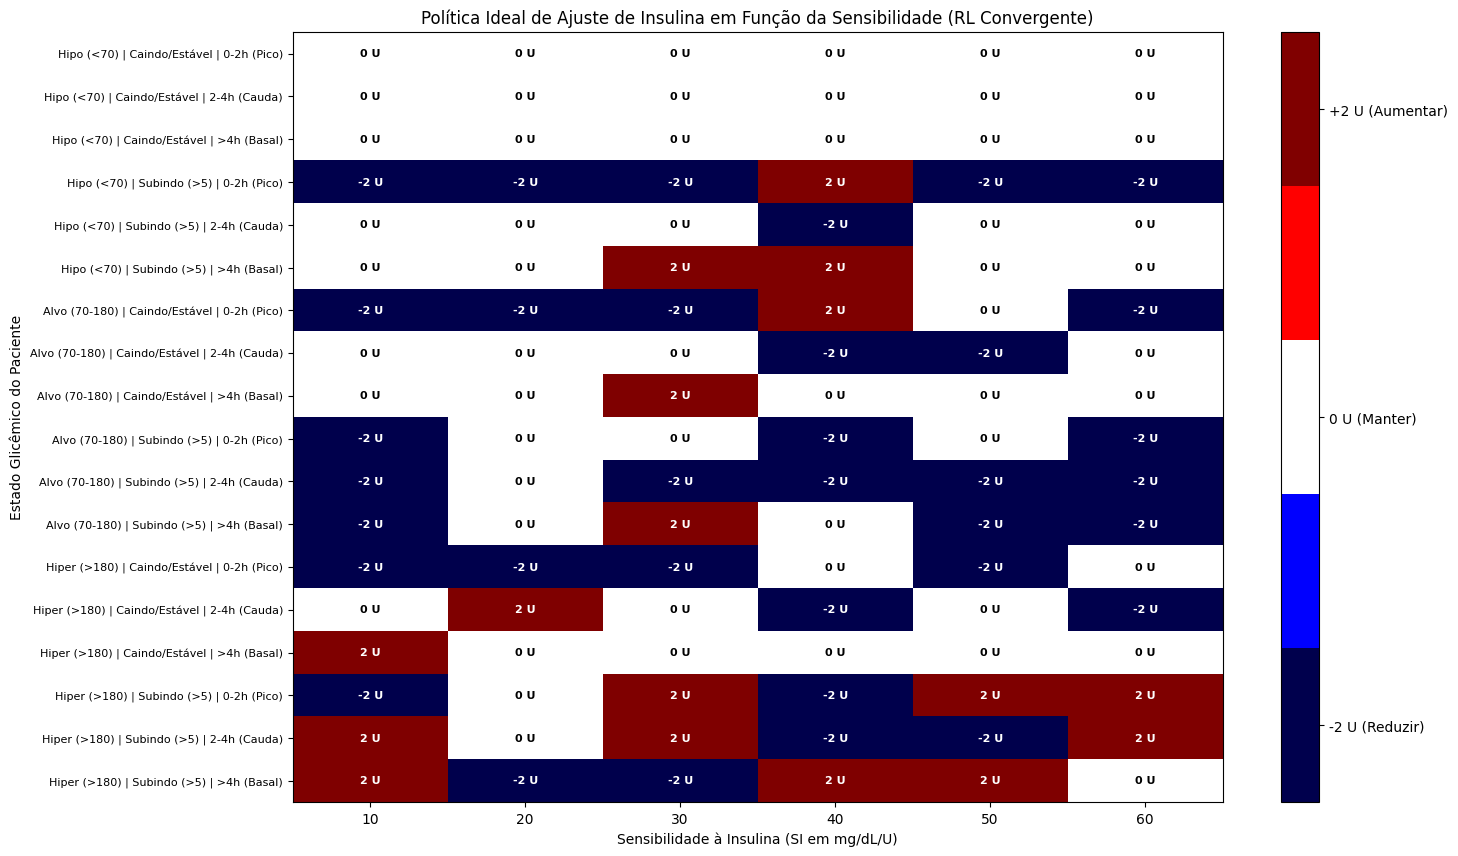

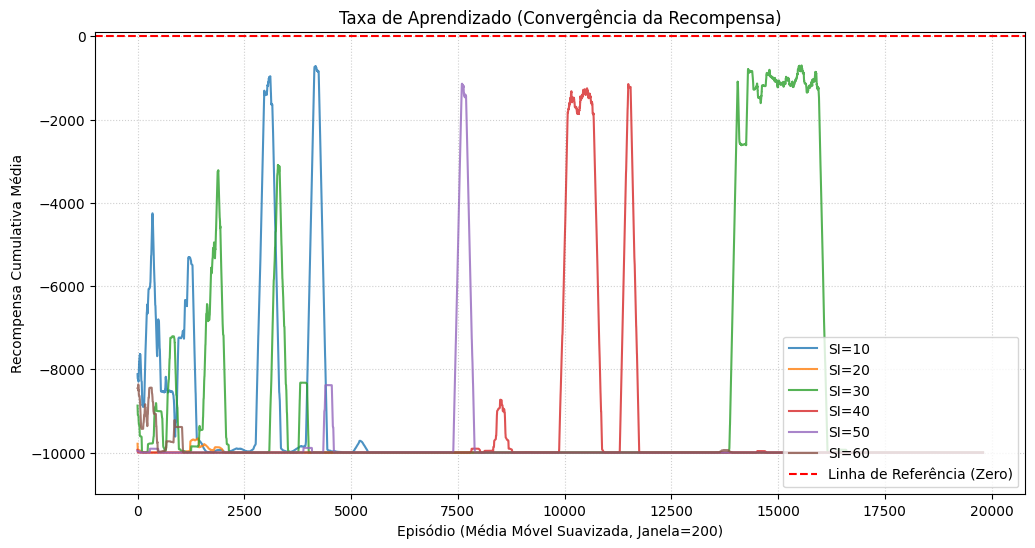

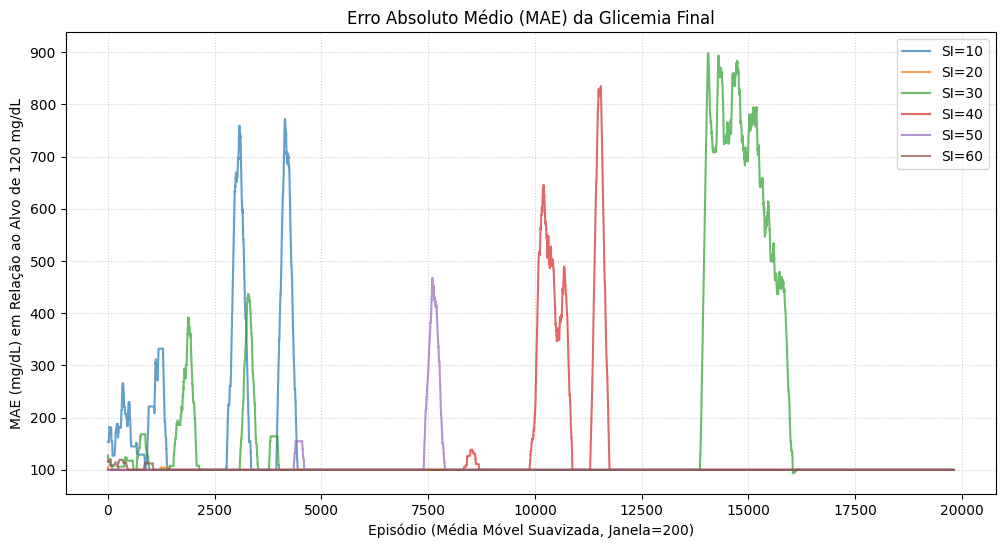

In [9]:
executar_analise_si()